# PRSice-2

In this notebook, we will use PRSice-2 to calculate the Polygenic Risk Score (PRS).

**Note:** PRSice-2 needs to be installed or placed in the same directory as this notebook.

1. It can be downloaded from this link: [PRSice-2](https://choishingwan.github.io/PRSice/).
2. Download the tool and name the executable file as `PRSice`, and it also contains the `PRSice.R` file required for execution.
3. We recommend using Linux. In cases where Windows is required due to package installation issues on Linux, we provide the following guidance:

   1. For Windows, use `PRSice`.
   2. For Linux, use `./PRSice`.



## PRSice-2 Hyperparameters

[PRSice](https://choishingwan.github.io/PRSice/) is the tool that allows calculating polygenic risk scores using a GWAS file and target data.

It enables clumping on the data, but in our case, we will perform clumping and pruning using PLINK rather than PRSice-2 and pass the processed data to PRSice-2. PRSice-2 also allows specifying the minimum and maximum p-values along with the interval, similar to PLINK.

### Hyperparameters for PRSice-2 performed using PLINK


#### Pruning Parameters

Informs Plink that we wish to perform pruning with a window size of 200 variants, sliding across the genome with a step size of 50 variants at a time, and filter out any SNPs with LD \( r^2 \) higher than 0.25.

```python
1. p_window_size = [200]
2. p_slide_size = [50]
3. p_LD_threshold = [0.25]
```

#### Clumping Parameters

The P-value threshold for an SNP to be included. 1 means to include all SNPs for clumping. SNPs having \( r^2 \) higher than 0.1 with the index SNPs will be removed. SNPs within 200k of the index SNP are considered for clumping.

```python
1. clump_p1 = [1]
2. clump_r2 = [0.1]
3. clump_kb = [200]
```
#### PCA
Pca also affects the results evident from the initial analysis; however, including more PCA overfits the model. 

### Hyperparameters for PRSice-2

These parameters can be passed to PRSice-2.

#### P-value Range

This is equivalent to Plink's `--q-score-range`. It's important to note that PRSice-2 does not return the results for each P-value threshold, but there is a flag `--all-score` that allows to get PRS for each p-value threshold.
- `--lower`
- `--upper`
- `--interval`

#### Models

PRSice-2 offers four models to be used for scoring. [Documentation](https://choishingwan.github.io/PRSice/step_by_step/#ld-reference)

1. avg
2. sum
3. std
4. con-std





## GWAS File Processing for PRSice-2

**The processing is the same as Plink.**

When the effect size relates to disease risk and is given as an odds ratio (OR) rather than BETA (for continuous traits), the PRS is computed as a product of ORs. To simplify this calculation, take the natural logarithm of the OR so that the PRS can be compu



In [2]:
import os
import pandas as pd
import numpy as np
import sys

#filedirec = sys.argv[1]

filedirec = "SampleData1"
#filedirec = "asthma_19"
#filedirec = "migraine_0"

def check_phenotype_is_binary_or_continous(filedirec):
    # Read the processed quality controlled file for a phenotype
    df = pd.read_csv(filedirec+os.sep+filedirec+'_QC.fam',sep="\s+",header=None)
    column_values = df[5].unique()
 
    if len(set(column_values)) == 2:
        return "Binary"
    else:
        return "Continous"



# Read the GWAS file.
GWAS = filedirec + os.sep + filedirec+".gz"
df = pd.read_csv(GWAS,compression= "gzip",sep="\s+")

if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
    if "BETA" in df.columns.to_list():
        # For Binary Phenotypes.
        df["OR"] = np.exp(df["BETA"])
        df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'OR', 'INFO', 'MAF']]
 
    else:
        # For Binary Phenotype.
        df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'OR', 'INFO', 'MAF']]
 
elif check_phenotype_is_binary_or_continous(filedirec)=="Continous":
    if "BETA" in df.columns.to_list():
        # For Continous Phenotype.
        df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]

    else:
        df["BETA"] = np.log(df["OR"])
        df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]

 
    

 
  

df.to_csv(filedirec + os.sep +filedirec+".txt",sep="\t",index=False)

df.to_csv(filedirec + os.sep +filedirec+"_PRSice-2.txt",sep="\t",index=False)
print(df.head().to_markdown())
print("Length of DataFrame!",len(df))


|    |   CHR |     BP | SNP        | A1   | A2   |      N |         SE |        P |        BETA |     INFO |      MAF |
|---:|------:|-------:|:-----------|:-----|:-----|-------:|-----------:|---------:|------------:|---------:|---------:|
|  0 |     1 | 756604 | rs3131962  | A    | G    | 388028 | 0.00301666 | 0.483171 | -0.00211532 | 0.890558 | 0.36939  |
|  1 |     1 | 768448 | rs12562034 | A    | G    | 388028 | 0.00329472 | 0.834808 |  0.00068708 | 0.895894 | 0.336846 |
|  2 |     1 | 779322 | rs4040617  | G    | A    | 388028 | 0.00303344 | 0.42897  | -0.00239932 | 0.897508 | 0.377368 |
|  3 |     1 | 801536 | rs79373928 | G    | T    | 388028 | 0.00841324 | 0.808999 |  0.00203363 | 0.908963 | 0.483212 |
|  4 |     1 | 808631 | rs11240779 | G    | A    | 388028 | 0.00242821 | 0.590265 |  0.00130747 | 0.893213 | 0.45041  |
Length of DataFrame! 499617


### Define Hyperparameters

Define hyperparameters to be optimized and set initial values.

### Extract Valid SNPs from Clumped File

For Windows, download `gwak`, and for Linux, the `awk` command is sufficient. For Windows, `GWAK` is required. You can download it from [here](https://sourceforge.net/projects/gnuwin32/). Get it and place it in the same directory.


### Execution Path

At this stage, we have the genotype training data `newtrainfilename = "train_data.QC"` and genotype test data `newtestfilename = "test_data.QC"`.

We modified the following variables:

1. `filedirec = "SampleData1"` or `filedirec = sys.argv[1]`
2. `foldnumber = "0"` or `foldnumber = sys.argv[2]` for HPC.

Only these two variables can be modified to execute the code for specific data and specific folds. Though the code can be executed separately for each fold on HPC and separately for each dataset, it is recommended to execute it for multiple diseases and one fold at a time.
Here’s the corrected text in Markdown format:

 
### P-values

PRS calculation relies on P-values. SNPs with low P-values, indicating a high degree of association with a specific trait, are considered for calculation.

You can modify the code below to consider a specific set of P-values and save the file in the same format.

We considered the following parameters:

- **Minimum P-value**: `1e-10`
- **Maximum P-value**: `1.0`
- **Minimum exponent**: `10`  (Minimum P-value in exponent)
- **Number of intervals**: `100`  (Number of intervals to be considered)

The code generates an array of logarithmically spaced P-values:

```python
import numpy as np
import os

minimumpvalue = 10  # Minimum exponent for P-values
numberofintervals = 100  # Number of intervals to be considered

allpvalues = np.logspace(-minimumpvalue, 0, numberofintervals, endpoint=True)  # Generating an array of logarithmically spaced P-values

print("Minimum P-value:", allpvalues[0])
print("Maximum P-value:", allpvalues[-1])

count = 1
with open(os.path.join(folddirec, 'range_list'), 'w') as file:
    for value in allpvalues:
        file.write(f'pv_{value} 0 {value}\n')  # Writing range information to the 'range_list' file
        count += 1

pvaluefile = os.path.join(folddirec, 'range_list')
```

In this code:
- `minimumpvalue` defines the minimum exponent for P-values.
- `numberofintervals` specifies how many intervals to consider.
- `allpvalues` generates an array of P-values spaced logarithmically.
- The script writes these P-values to a file named `range_list` in the specified directory.
 

In [22]:
from operator import index
import pandas as pd
import numpy as np
import os
import subprocess
import sys
import pandas as pd
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix
from statsmodels.stats.contingency_tables import mcnemar

def create_directory(directory):
    """Function to create a directory if it doesn't exist."""
    if not os.path.exists(directory):  # Checking if the directory doesn't exist
        os.makedirs(directory)  # Creating the directory if it doesn't exist
    return directory  # Returning the created or existing directory

 
#foldnumber = sys.argv[2]
foldnumber = "0"  # Setting 'foldnumber' to "0"

folddirec = filedirec + os.sep + "Fold_" + foldnumber  # Creating a directory path for the specific fold
trainfilename = "train_data"  # Setting the name of the training data file
newtrainfilename = "train_data.QC"  # Setting the name of the new training data file

testfilename = "test_data"  # Setting the name of the test data file
newtestfilename = "test_data.QC"  # Setting the name of the new test data file

# Number of PCA to be included as a covariate.
numberofpca = ["6"]  # Setting the number of PCA components to be included

# Clumping parameters.
clump_p1 = [1]  # List containing clump parameter 'p1'
clump_r2 = [0.1]  # List containing clump parameter 'r2'
clump_kb = [200]  # List containing clump parameter 'kb'

# Pruning parameters.
p_window_size = [200]  # List containing pruning parameter 'window_size'
p_slide_size = [50]  # List containing pruning parameter 'slide_size'
p_LD_threshold = [0.25]  # List containing pruning parameter 'LD_threshold'

# Kindly note that the number of p-values to be considered varies, and the actual p-value depends on the dataset as well.
# We will specify the range list here.

minimumpvalue = 4  # Minimum p-value in exponent
numberofintervals = 10  # Number of intervals to be considered
allpvalues = np.logspace(-minimumpvalue, 0, numberofintervals, endpoint=True)  # Generating an array of logarithmically spaced p-values
count = 1
with open(folddirec + os.sep + 'range_list', 'w') as file:
    for value in allpvalues:
        file.write(f'pv_{value} 0 {value}\n')  # Writing range information to the 'range_list' file
        count = count + 1


# PRSice-2 consider maximum an minimum p-values with constant interval. Whereas, in plink, we can specify a specific range of values.        
minimumpvalue = str(1e-5)  # Minimum p-value in exponent
maximumpvalue = str(1)  # Maximum p-value in exponent
interval = str(0.1)
pvalues = np.arange(1e-5,1,0.1)

print("Minimum P-value",pvalues[0])
print("Maximum P-value",pvalues[-1])
print("Number of P-values",len(pvalues))
# For PRSice-2, we do not need to store the p-values in a file.
pvaluefile = folddirec + os.sep + 'range_list'
        
pvaluefile = folddirec + os.sep + 'range_list'

# Initializing an empty DataFrame with specified column names
prs_result = pd.DataFrame(columns=["clump_p1", "clump_r2", "clump_kb", "p_window_size", "p_slide_size", "p_LD_threshold",
                                   "pvalue", "numberofpca","numberofvariants","Train_pure_prs", "Train_null_model", "Train_best_model",
                                   "Test_pure_prs", "Test_null_model", "Test_best_model"])

Minimum P-value 1e-05
Maximum P-value 0.90001
Number of P-values 10


### LD Reference Panel
PRSice-2 allows the use of the LD reference panel when calculating the Polygenic Risk Score (PRS). We followed the tutorial outlined in [this document](https://dougspeed.com/reference-panel/) with minor modifications to incorporate the LD reference panel into the process.

For a detailed explanation of how PRSice-2 utilizes the LD reference, please refer to [this page](https://choishingwan.github.io/PRSice/step_by_step/#ld-reference). If you wish to include the LD reference panel in the PRSice-2 calculation, use the flag "--ld" and provide the reference files.

### LD Calculation
Various PRS tools use LD files in different formats. If a tool utilizes an LD reference, the specifics will be explained in the documentation of each tool.

There are two methods to obtain the LD reference:
1. For PRSice-2, we followed the process outlined [here](https://dougspeed.com/reference-panel/) for LD calculation, as the data pertains to the European population.
2. Alternatively, you can download the 1000 Genome project, calculate the LD with specific parameters, and extract SNPs from the LD file.

**Use Linux for LD calculation using this https://dougspeed.com/reference-panel/ tutorial.**

Download [Plink2](https://www.cog-genomics.org/plink/2.0/) as recommended by the author of the above-mentioned tutorial.

**Using an external reference panel for any tool restricts the analysis to the SNPs remaining after clumping and pruning and the ones that exist in the data.**


```bash
wget https://www.dropbox.com/s/y6ytfoybz48dc0u/all_phase3.pgen.zst
wget https://www.dropbox.com/s/odlexvo8fummcvt/all_phase3.pvar.zst
wget https://www.dropbox.com/s/6ppo144ikdzery5/phase3_corrected.psam

./plink2 --zst-decompress all_phase3.pgen.zst > all_phase3_ns.pgen
./plink2 --zst-decompress all_phase3.pvar.zst > all_phase3_ns.pvar

awk < phase3_corrected.psam '($5=="EUR" && $6!="FIN"){print 0, $1}' > eur.keep
echo "." > exclude.snps
./plink2 --make-bed --out raw --pgen all_phase3_ns.pgen --pvar all_phase3_ns.pvar --psam phase3_corrected.psam --maf 0.01 --autosome --snps-only just-acgt --max-alleles 2 --rm-dup exclude-all --exclude exclude.snps --keep eur.keep
awk '(NR==FNR){arr[$1]=$5"_"$6;ars[$1]=$4;next}{$1=$2;$2=arr[$1];$5=ars[$1];print $0}' phase3_corrected.psam raw.fam > clean.fam
cp raw.bim clean.bim
cp raw.bed clean.bed
wget https://www.dropbox.com/s/slchsd0uyd4hii8/genetic_map_b37.zip
unzip genetic_map_b37.zip
./plink --bfile clean --cm-map genetic_map_b37/genetic_map_chr@_combined_b37.txt --make-bed --out ref
```


You should have the following files:

1. `ref.bim`
2. `ref.fam`
3. `ref.bed`

If you wish to include the LD reference panel in the PRSice-2 calculation, use the flag "--ld" and provide the reference files.

The genomic build of the LD reference panel, genotype data and the GWAS should be the same.



### Define Helper Functions

1. **Perform Clumping and Pruning**
2. **Calculate PCA Using Plink**
3. **Fit Binary Phenotype and Save Results**
4. **Fit Continuous Phenotype and Save Results**


In [23]:
import os
import subprocess
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score


def perform_clumping_and_pruning_on_individual_data(traindirec, newtrainfilename,numberofpca, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    
    command = [
    "./plink",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--out", traindirec+os.sep+trainfilename
    ]
    subprocess.run(command)
    # First perform pruning and then clumping and the pruning.

    command = [
    "./plink",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--clump-p1", c1_val,
    "--extract", traindirec+os.sep+trainfilename+".prune.in",
    "--clump-r2", c2_val,
    "--clump-kb", c3_val,
    "--clump", filedirec+os.sep+filedirec+".txt",
    "--clump-snp-field", "SNP",
    "--clump-field", "P",
    "--out", traindirec+os.sep+trainfilename
    ]    
    subprocess.run(command)

    # Extract the valid SNPs from th clumped file.
    # For windows download gwak for linux awk commmand is sufficient.
    ### For windows require GWAK.
    ### https://sourceforge.net/projects/gnuwin32/
    ##3 Get it and place it in the same direc.
    #os.system("gawk "+"\""+"NR!=1{print $3}"+"\"  "+ traindirec+os.sep+trainfilename+".clumped >  "+traindirec+os.sep+trainfilename+".valid.snp")
    #print("gawk "+"\""+"NR!=1{print $3}"+"\"  "+ traindirec+os.sep+trainfilename+".clumped >  "+traindirec+os.sep+trainfilename+".valid.snp")

    #Linux:
    command = f"awk 'NR!=1{{print $3}}' {traindirec}{os.sep}{trainfilename}.clumped > {traindirec}{os.sep}{trainfilename}.valid.snp"
    os.system(command)
    
    
    command = [
    "./plink",
    "--make-bed",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--extract", traindirec+os.sep+trainfilename+".valid.snp",
    "--out", traindirec+os.sep+newtrainfilename+".clumped.pruned"
    ]
    subprocess.run(command)
    
    command = [
    "./plink",
    "--make-bed",
    "--bfile", traindirec+os.sep+testfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--extract", traindirec+os.sep+trainfilename+".valid.snp",
    "--out", traindirec+os.sep+testfilename+".clumped.pruned"
    ]
    subprocess.run(command)    
    
    
 
def calculate_pca_for_traindata_testdata_for_clumped_pruned_snps(traindirec, newtrainfilename,p):
    
    # Calculate the PRS for the test data using the same set of SNPs and also calculate the PCA.


    # Also extract the PCA at this point.
    # PCA are calculated afer clumping and pruining.
    command = [
        "./plink",
        "--bfile", folddirec+os.sep+testfilename+".clumped.pruned",
        # Select the final variants after clumping and pruning.
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--pca", p,
        "--out", folddirec+os.sep+testfilename
    ]
    subprocess.run(command)


    command = [
    "./plink",
        "--bfile", traindirec+os.sep+newtrainfilename+".clumped.pruned",
        # Select the final variants after clumping and pruning.        
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--pca", p,
        "--out", traindirec+os.sep+trainfilename
    ]
    subprocess.run(command)



# This function fit the binary model on the PRS.
def fit_binary_phenotype_on_PRS(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    threshold_values = allpvalues

    # Merge the covariates, pca and phenotypes.
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_train = pd.DataFrame()
    phenotype_train["Phenotype"] = tempphenotype_train[5].values
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.fillna(0, inplace=True)


    ## Scale the covariates!
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import explained_variance_score
    scaler = MinMaxScaler()
    normalized_values_train = scaler.fit_transform(covandpcs_train.iloc[:, 2:])
    #covandpcs_train.iloc[:, 2:] = normalized_values_test 
    
    
    tempphenotype_test = pd.read_table(traindirec+os.sep+testfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_test= pd.DataFrame()
    phenotype_test["Phenotype"] = tempphenotype_test[5].values
    pcs_test = pd.read_table(traindirec+os.sep+testfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_test = pd.read_table(traindirec+os.sep+testfilename+".cov",sep="\s+")
    covariate_test.fillna(0, inplace=True)
    covariate_test = covariate_test[covariate_test["FID"].isin(pcs_test["FID"].values) & covariate_test["IID"].isin(pcs_test["IID"].values)]
    covariate_test['FID'] = covariate_test['FID'].astype(str)
    pcs_test['FID'] = pcs_test['FID'].astype(str)
    covariate_test['IID'] = covariate_test['IID'].astype(str)
    pcs_test['IID'] = pcs_test['IID'].astype(str)
    covandpcs_test = pd.merge(covariate_test, pcs_test, on=["FID","IID"])
    covandpcs_test.fillna(0, inplace=True)
    normalized_values_test  = scaler.transform(covandpcs_test.iloc[:, 2:])
    #covandpcs_test.iloc[:, 2:] = normalized_values_test     
    
    
    
    
    tempalphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    l1weights = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    tempalphas = [0.1]
    l1weights = [0.1]

    phenotype_train["Phenotype"] = phenotype_train["Phenotype"].replace({1: 0, 2: 1}) 
    phenotype_test["Phenotype"] = phenotype_test["Phenotype"].replace({1: 0, 2: 1})

    train_all_prs_direc = traindirec+os.sep+Name+os.sep+p+"_"+prsicemodel+"_Train_PRSice_PRS_"+p1_val+"_"+p2_val+"_"+p3_val+"_"+c1_val+"_"+c2_val+"_"+c3_val
    test_all_prs_direc = traindirec+os.sep+Name+os.sep+p+"_"+prsicemodel+"_Test_PRSice_PRS_"+p1_val+"_"+p2_val+"_"+p3_val+"_"+c1_val+"_"+c2_val+"_"+c3_val
 
    train_prs_frame = pd.read_csv(train_all_prs_direc+".all_score",sep="\s+")
    test_prs_frame = pd.read_csv(test_all_prs_direc+".all_score",sep="\s+")
    pvalues = train_prs_frame.columns.tolist()[2:]
    
    
    for tempalpha in tempalphas:
        for l1weight in l1weights:

            
            try:
                null_model =  sm.Logit(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                #null_model =  sm.Logit(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
            
            except:
                print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
                continue

            train_null_predicted = null_model.predict(sm.add_constant(covandpcs_train.iloc[:, 2:]))
            
            from sklearn.metrics import roc_auc_score, confusion_matrix
            from sklearn.metrics import r2_score
            
            test_null_predicted = null_model.predict(sm.add_constant(covandpcs_test.iloc[:, 2:]))
            
            global prs_result
           
             
            for i in pvalues:
                try:
                    prs_train = pd.read_table(train_all_prs_direc+".all_score", sep="\s+", usecols=["FID", "IID", i])
                except:
                    continue

                prs_train['FID'] = prs_train['FID'].astype(str)
                prs_train['IID'] = prs_train['IID'].astype(str)
                try:
                    prs_test = pd.read_table(test_all_prs_direc+".all_score", sep="\s+", usecols=["FID", "IID", i])
                except:
                    continue
                prs_test['FID'] = prs_test['FID'].astype(str)
                prs_test['IID'] = prs_test['IID'].astype(str)
                pheno_prs_train = pd.merge(covandpcs_train, prs_train, on=["FID", "IID"])
                pheno_prs_test = pd.merge(covandpcs_test, prs_test, on=["FID", "IID"])
        
                try:
                    model = sm.Logit(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                    #model = sm.Logit(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit()
                
                except:
                    continue


                
                train_best_predicted = model.predict(sm.add_constant(pheno_prs_train.iloc[:, 2:]))    
 

                test_best_predicted = model.predict(sm.add_constant(pheno_prs_test.iloc[:, 2:])) 
 
        
                from sklearn.metrics import roc_auc_score, confusion_matrix

                prs_result = prs_result._append({
                    "clump_p1": c1_val,
                    "clump_r2": c2_val,
                    "clump_kb": c3_val,
                    "p_window_size": p1_val,
                    "p_slide_size": p2_val,
                    "p_LD_threshold": p3_val,
                    "pvalue": i,
                    "numberofpca":p, 

                    "tempalpha":str(tempalpha),
                    "l1weight":str(l1weight),
                    #"numberofvariants": len(pd.read_csv(traindirec+os.sep+newtrainfilename+".clumped.pruned.bim")),
                    
                     
                    "PRSice-2_Model":prsicemodel,
                    "Train_pure_prs":roc_auc_score(phenotype_train["Phenotype"].values,prs_train[i]),
                    "Train_null_model":roc_auc_score(phenotype_train["Phenotype"].values,train_null_predicted.values),
                    "Train_best_model":roc_auc_score(phenotype_train["Phenotype"].values,train_best_predicted.values),
                    
                    "Test_pure_prs":roc_auc_score(phenotype_test["Phenotype"].values,prs_test[i]),
                    "Test_null_model":roc_auc_score(phenotype_test["Phenotype"].values,test_null_predicted.values),
                    "Test_best_model":roc_auc_score(phenotype_test["Phenotype"].values,test_best_predicted.values),
                    
                }, ignore_index=True)

          
                prs_result.to_csv(traindirec+os.sep+Name+os.sep+"Results.csv",index=False)
     
    return

# This function fit the binary model on the PRS.
def fit_continous_phenotype_on_PRS(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    threshold_values = allpvalues

    # Merge the covariates, pca and phenotypes.
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_train = pd.DataFrame()
    phenotype_train["Phenotype"] = tempphenotype_train[5].values
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.fillna(0, inplace=True)


    ## Scale the covariates!
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import explained_variance_score
    scaler = MinMaxScaler()
    normalized_values_train = scaler.fit_transform(covandpcs_train.iloc[:, 2:])
    #covandpcs_train.iloc[:, 2:] = normalized_values_test 
    
    tempphenotype_test = pd.read_table(traindirec+os.sep+testfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_test= pd.DataFrame()
    phenotype_test["Phenotype"] = tempphenotype_test[5].values
    pcs_test = pd.read_table(traindirec+os.sep+testfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_test = pd.read_table(traindirec+os.sep+testfilename+".cov",sep="\s+")
    covariate_test.fillna(0, inplace=True)
    covariate_test = covariate_test[covariate_test["FID"].isin(pcs_test["FID"].values) & covariate_test["IID"].isin(pcs_test["IID"].values)]
    covariate_test['FID'] = covariate_test['FID'].astype(str)
    pcs_test['FID'] = pcs_test['FID'].astype(str)
    covariate_test['IID'] = covariate_test['IID'].astype(str)
    pcs_test['IID'] = pcs_test['IID'].astype(str)
    covandpcs_test = pd.merge(covariate_test, pcs_test, on=["FID","IID"])
    covandpcs_test.fillna(0, inplace=True)
    normalized_values_test  = scaler.transform(covandpcs_test.iloc[:, 2:])
    #covandpcs_test.iloc[:, 2:] = normalized_values_test     
    
    
    
    
    tempalphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    l1weights = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    tempalphas = [0.1]
    l1weights = [0.1]

    #phenotype_train["Phenotype"] = phenotype_train["Phenotype"].replace({1: 0, 2: 1}) 
    #phenotype_test["Phenotype"] = phenotype_test["Phenotype"].replace({1: 0, 2: 1})
    
    train_all_prs_direc = traindirec+os.sep+Name+os.sep+p+"_"+prsicemodel+"_Train_PRSice_PRS_"+p1_val+"_"+p2_val+"_"+p3_val+"_"+c1_val+"_"+c2_val+"_"+c3_val
    test_all_prs_direc = traindirec+os.sep+Name+os.sep+p+"_"+prsicemodel+"_Test_PRSice_PRS_"+p1_val+"_"+p2_val+"_"+p3_val+"_"+c1_val+"_"+c2_val+"_"+c3_val
 
    train_prs_frame = pd.read_csv(train_all_prs_direc+".all_score",sep="\s+")
    test_prs_frame = pd.read_csv(test_all_prs_direc+".all_score",sep="\s+")
    pvalues = train_prs_frame.columns.tolist()[2:]
    
    
    
    
    for tempalpha in tempalphas:
        for l1weight in l1weights:

            
            try:
                #null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
                #null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
            except:
                print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
                continue

            train_null_predicted = null_model.predict(sm.add_constant(covandpcs_train.iloc[:, 2:]))
            
            from sklearn.metrics import roc_auc_score, confusion_matrix
            from sklearn.metrics import r2_score
            
            test_null_predicted = null_model.predict(sm.add_constant(covandpcs_test.iloc[:, 2:]))
            
            
            
            global prs_result
            for i in pvalues:
                actualvalue = i.replace("Pt_","")
                try:
                    prs_train = pd.read_table(train_all_prs_direc+".all_score", sep="\s+", usecols=["FID", "IID", i])
                except:
                    continue
                    
                prs_train['FID'] = prs_train['FID'].astype(str)
                prs_train['IID'] = prs_train['IID'].astype(str)
                
                try:
                    prs_test = pd.read_table(test_all_prs_direc+".all_score", sep="\s+", usecols=["FID", "IID", i])
                except:
                    continue
                    
                prs_test = pd.read_table(test_all_prs_direc+".all_score", sep="\s+", usecols=["FID", "IID", i])
                prs_test['FID'] = prs_test['FID'].astype(str)
                prs_test['IID'] = prs_test['IID'].astype(str)

                pheno_prs_train = pd.merge(covandpcs_train, prs_train, on=["FID", "IID"])
                pheno_prs_test = pd.merge(covandpcs_test, prs_test, on=["FID", "IID"])            
 
        
                try:
                    #model = sm.OLS(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                    model = sm.OLS(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit()
                
                except:
                    continue


                
                train_best_predicted = model.predict(sm.add_constant(pheno_prs_train.iloc[:, 2:]))    
                test_best_predicted = model.predict(sm.add_constant(pheno_prs_test.iloc[:, 2:])) 
 
        
                from sklearn.metrics import roc_auc_score, confusion_matrix

                prs_result = prs_result._append({
                    "clump_p1": c1_val,
                    "clump_r2": c2_val,
                    "clump_kb": c3_val,
                    "p_window_size": p1_val,
                    "p_slide_size": p2_val,
                    "p_LD_threshold": p3_val,
                    "pvalue": i,
                    "numberofpca":p, 

                    "tempalpha":str(tempalpha),
                    "l1weight":str(l1weight),
                    #"numberofvariants": len(pd.read_csv(traindirec+os.sep+newtrainfilename+".clumped.pruned.bim")),
                    "PRSice-2_Model":prsicemodel,

                    "Train_pure_prs":explained_variance_score(phenotype_train["Phenotype"],prs_train[i]),
                    "Train_null_model":explained_variance_score(phenotype_train["Phenotype"],train_null_predicted),
                    "Train_best_model":explained_variance_score(phenotype_train["Phenotype"],train_best_predicted),
                    "Test_pure_prs":explained_variance_score(phenotype_test["Phenotype"],prs_test[i]),
                    "Test_null_model":explained_variance_score(phenotype_test["Phenotype"],test_null_predicted),
                    "Test_best_model":explained_variance_score(phenotype_test["Phenotype"],test_best_predicted),
                    
                }, ignore_index=True)

          
                prs_result.to_csv(traindirec+os.sep+Name+os.sep+"Results.csv",index=False)
     
    return
    


## Execute PRSice-2

Kindly read the comments for understanding the flow.
We will first perform clumping and pruning using Plink, and store the processed data.


In [24]:

# Define a global variable to store results
prs_result = pd.DataFrame()
def transform_prsice_data(traindirec, newtrainfilename,prsicemodel,numberofpca, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    ### First perform clumping on the file and save the clumpled file.
    perform_clumping_and_pruning_on_individual_data(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)
    
 
    # Also extract the PCA at this point for both test and training data.
    calculate_pca_for_traindata_testdata_for_clumped_pruned_snps(traindirec, newtrainfilename,p)

    #Extract p-values from the GWAS file.
    os.system("awk "+"\'"+"{print $3,$8}"+"\'"+" ./"+filedirec+os.sep+filedirec+".txt >  ./"+traindirec+os.sep+"SNP.pvalue")

    
    # At this stage, we will merge the PCA and COV file. 
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype = pd.DataFrame()
    phenotype = tempphenotype_train[[0,1,5]]
    phenotype.to_csv(traindirec+os.sep+trainfilename+".PHENO",sep="\t",header=['FID', 'IID', 'PHENO'],index=False)
 
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    print(covariate_train.head())
    print(len(covariate_train))
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    print(len(covariate_train))
 
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.to_csv(traindirec+os.sep+trainfilename+".COV_PCA",sep="\t",index=False)
    binary_phenotype = ""
    stat_col = ""
    if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
        binary_phenotype = 'T'
        stat_col="OR"
    
    else:
        binary_phenotype = 'F'
        stat_col="BETA"
        
    command = [
    './PRSice',
    '--base', filedirec + os.sep +filedirec+"_PRSice-2.txt",
    '--target', traindirec+os.sep+newtrainfilename+".clumped.pruned",
    '--pheno', traindirec+os.sep+trainfilename+".PHENO",
    '--cov', traindirec+os.sep+trainfilename+".COV_PCA",
    '--stat', stat_col,
    #'--beta',
    # If you want to use the LD reference.
    '--ld','ref',
    '--all-score',
    '--lower', minimumpvalue, 
    '--upper',maximumpvalue,
    '--interval',interval,
    '--score',prsicemodel,
    '--binary-target', binary_phenotype,
    '--no-clump',
    '--out', traindirec+os.sep+Name+os.sep+p+"_"+prsicemodel+"_Train_PRSice_PRS_"+p1_val+"_"+p2_val+"_"+p3_val+"_"+c1_val+"_"+c2_val+"_"+c3_val
    ]
    subprocess.run(command)

 
 

    tempphenotype_test = pd.read_table(traindirec+os.sep+testfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype = pd.DataFrame()
    phenotype = tempphenotype_test[[0,1,5]]
    phenotype.to_csv(traindirec+os.sep+testfilename+".PHENO",sep="\t",header=['FID', 'IID', 'PHENO'],index=False)
 
    pcs_test = pd.read_table(traindirec+os.sep+testfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_test = pd.read_table(traindirec+os.sep+testfilename+".cov",sep="\s+")
    covariate_test.fillna(0, inplace=True)
 
 
    covariate_test = covariate_test[covariate_test["FID"].isin(pcs_test["FID"].values) & covariate_test["IID"].isin(pcs_test["IID"].values)]
 
    covariate_test['FID'] = covariate_test['FID'].astype(str)
    pcs_test['FID'] = pcs_test['FID'].astype(str)
    covariate_test['IID'] = covariate_test['IID'].astype(str)
    pcs_test['IID'] = pcs_test['IID'].astype(str)
    covandpcs_test = pd.merge(covariate_test, pcs_test, on=["FID","IID"])
    covandpcs_test.to_csv(traindirec+os.sep+testfilename+".COV_PCA",sep="\t",index=False)
    
    command = [
    './PRSice',
    '--base', filedirec + os.sep +filedirec+"_PRSice-2.txt",
    '--target', traindirec+os.sep+testfilename+".clumped.pruned",
    '--pheno', traindirec+os.sep+testfilename+".PHENO",
    '--cov', traindirec+os.sep+testfilename+".COV_PCA",
    '--stat', stat_col,
    #'--beta',
    # If you want to use the LD reference.
    '--ld','ref',
    '--all-score',
    '--lower', minimumpvalue, 
    '--upper',maximumpvalue,
    '--interval',interval,
    '--score',prsicemodel,
    '--binary-target', binary_phenotype,
    '--no-clump',
    '--out', traindirec+os.sep+Name+os.sep+p+"_"+prsicemodel+"_Test_PRSice_PRS_"+p1_val+"_"+p2_val+"_"+p3_val+"_"+c1_val+"_"+c2_val+"_"+c3_val
    ]
    subprocess.run(command)

    if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
        print("Binary Phenotype!")
        fit_binary_phenotype_on_PRS(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)
    else:
        print("Continous Phenotype!")
        fit_continous_phenotype_on_PRS(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)
    return        
 
     
 

 
PRSiceModels =  ['avg','sum','std','con-std']
#PRSiceModels =  ['avg']
result_directory = "PRSice-2"
# Nested loops to iterate over different parameter values
create_directory(folddirec+os.sep+result_directory)
for p1_val in p_window_size:
 for p2_val in p_slide_size: 
  for p3_val in p_LD_threshold:
   for c1_val in clump_p1:
    for c2_val in clump_r2:
     for c3_val in clump_kb:
      for p in numberofpca:
       for prsicemodel in  PRSiceModels:
        transform_prsice_data(folddirec, newtrainfilename,prsicemodel, p, str(p1_val), str(p2_val), str(p3_val), str(c1_val), str(c2_val), str(c3_val), result_directory, pvaluefile)


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --indep-pairwise 200 50 0.25
  --out SampleData1/Fold_0/train_data

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999894.
491952 variants and 380 people pass filters and QC.
Phenotype data is quantitative.
Pruned

247090 more top variant IDs missing; see log file.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --extract SampleData1/Fold_0/train_data.valid.snp
  --indep-pairwise 200 50 0.25
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 172878 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495

PRSice 2.3.3 (2020-08-05) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2024-08-26 21:47:47
./PRSice \
    --a1 A1 \
    --a2 A2 \
    --all-score  \
    --bar-levels 0.001,0.05,0.1,0.2,0.3,0.4,0.5,1 \
    --base SampleData1/SampleData1_PRSice-2.txt \
    --base-info INFO:0.9 \
    --beta  \
    --binary-target F \
    --bp BP \
    --chr CHR \
    --cov SampleData1/Fold_0/train_data.COV_PCA \
    --interval 0.1 \
    --ld ref \
    --lower 1e-05 \
    --no-clump  \
    --num-auto 22 \
    --out SampleData1/Fold_0/PRSice-2/6_avg_Train_PRSice_PRS_200_50_0.25_1_0.1_200 \
    --pheno SampleData1/Fold_0/train_data.PHENO \
    --pvalue P \
    --score avg \
    --seed 554318882 \
    --snp SNP \
    --stat BETA \
    --target SampleData1/F

Continous Phenotype!
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --indep-pairwise 200 50 0.25
  --out SampleData1/Fold_0/train_data

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999894.
491952 variants and 380 people pass filters and QC.
Phenotype data is

247090 more top variant IDs missing; see log file.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --extract SampleData1/Fold_0/train_data.valid.snp
  --indep-pairwise 200 50 0.25
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 172878 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495

PRSice 2.3.3 (2020-08-05) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2024-08-26 21:48:21
./PRSice \
    --a1 A1 \
    --a2 A2 \
    --all-score  \
    --bar-levels 0.001,0.05,0.1,0.2,0.3,0.4,0.5,1 \
    --base SampleData1/SampleData1_PRSice-2.txt \
    --base-info INFO:0.9 \
    --beta  \
    --binary-target F \
    --bp BP \
    --chr CHR \
    --cov SampleData1/Fold_0/train_data.COV_PCA \
    --interval 0.1 \
    --ld ref \
    --lower 1e-05 \
    --no-clump  \
    --num-auto 22 \
    --out SampleData1/Fold_0/PRSice-2/6_sum_Train_PRSice_PRS_200_50_0.25_1_0.1_200 \
    --pheno SampleData1/Fold_0/train_data.PHENO \
    --pvalue P \
    --score sum \
    --seed 4175916236 \
    --snp SNP \
    --stat BETA \
    --target SampleData1/

Continous Phenotype!
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --indep-pairwise 200 50 0.25
  --out SampleData1/Fold_0/train_data

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999894.
491952 variants and 380 people pass filters and QC.
Phenotype data is

247090 more top variant IDs missing; see log file.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --extract SampleData1/Fold_0/train_data.valid.snp
  --indep-pairwise 200 50 0.25
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 172878 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495

PRSice 2.3.3 (2020-08-05) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2024-08-26 21:48:55
./PRSice \
    --a1 A1 \
    --a2 A2 \
    --all-score  \
    --bar-levels 0.001,0.05,0.1,0.2,0.3,0.4,0.5,1 \
    --base SampleData1/SampleData1_PRSice-2.txt \
    --base-info INFO:0.9 \
    --beta  \
    --binary-target F \
    --bp BP \
    --chr CHR \
    --cov SampleData1/Fold_0/train_data.COV_PCA \
    --interval 0.1 \
    --ld ref \
    --lower 1e-05 \
    --no-clump  \
    --num-auto 22 \
    --out SampleData1/Fold_0/PRSice-2/6_std_Train_PRSice_PRS_200_50_0.25_1_0.1_200 \
    --pheno SampleData1/Fold_0/train_data.PHENO \
    --pvalue P \
    --score std \
    --seed 702940124 \
    --snp SNP \
    --stat BETA \
    --target SampleData1/F

Continous Phenotype!
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --indep-pairwise 200 50 0.25
  --out SampleData1/Fold_0/train_data

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999894.
491952 variants and 380 people pass filters and QC.
Phenotype data is

247090 more top variant IDs missing; see log file.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/train_data.QC.clumped.pruned.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC
  --extract SampleData1/Fold_0/train_data.valid.snp
  --indep-pairwise 200 50 0.25
  --make-bed
  --out SampleData1/Fold_0/train_data.QC.clumped.pruned

63761 MB RAM detected; reserving 31880 MB for main workspace.
491952 variants loaded from .bim file.
380 people (183 males, 197 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 172878 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495

PRSice 2.3.3 (2020-08-05) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2024-08-26 21:49:30
./PRSice \
    --a1 A1 \
    --a2 A2 \
    --all-score  \
    --bar-levels 0.001,0.05,0.1,0.2,0.3,0.4,0.5,1 \
    --base SampleData1/SampleData1_PRSice-2.txt \
    --base-info INFO:0.9 \
    --beta  \
    --binary-target F \
    --bp BP \
    --chr CHR \
    --cov SampleData1/Fold_0/train_data.COV_PCA \
    --interval 0.1 \
    --ld ref \
    --lower 1e-05 \
    --no-clump  \
    --num-auto 22 \
    --out SampleData1/Fold_0/PRSice-2/6_con-std_Train_PRSice_PRS_200_50_0.25_1_0.1_200 \
    --pheno SampleData1/Fold_0/train_data.PHENO \
    --pvalue P \
    --score con-std \
    --seed 1394548693 \
    --snp SNP \
    --stat BETA \
    --target Samp

Continous Phenotype!


### Repeat the process for each fold.

Change the `foldnumber` variable.

```python
#foldnumber = sys.argv[1]
foldnumber = "0"  # Setting 'foldnumber' to "0"
```

Or uncomment the following line:
```python
# foldnumber = sys.argv[1]
python PRSice-2.py 0
python PRSice-2.py 1
python PRSice-2.py 2
python PRSice-2.py 3
python PRSice-2.py 4
```

The following files should exist after the execution:

1. `SampleData1/Fold_0/PRSice-2/Results.csv`
2. `SampleData1/Fold_1/PRSice-2/Results.csv`
3. `SampleData1/Fold_2/PRSice-2/Results.csv`
4. `SampleData1/Fold_3/PRSice-2/Results.csv`
5. `SampleData1/Fold_4/PRSice-2/Results.csv`


### Check the results file for each fold.

In [3]:
import os

 
# List of file names to check for existence
f = [
    "./"+filedirec+"/Fold_0"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_1"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_2"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_3"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_4"+os.sep+result_directory+"Results.csv",
]

 

# Loop through each file name in the list
for loop in range(0,5):
    # Check if the file exists in the specified directory for the given fold
    if os.path.exists(filedirec+os.sep+"Fold_"+str(loop)+os.sep+result_directory+os.sep+"Results.csv"):
        temp = pd.read_csv(filedirec+os.sep+"Fold_"+str(loop)+os.sep+result_directory+os.sep+"Results.csv")
        print("Fold_",loop, "Yes, the file exists.")
        #print(temp.head())
        print("Number of P-values processed: ",len(temp))
        # Print a message indicating that the file exists
    
    else:
        # Print a message indicating that the file does not exist
        print("Fold_",loop, "No, the file does not exist.")



Fold_ 0 Yes, the file exists.
Number of P-values processed:  44
Fold_ 1 Yes, the file exists.
Number of P-values processed:  22
Fold_ 2 Yes, the file exists.
Number of P-values processed:  22
Fold_ 3 Yes, the file exists.
Number of P-values processed:  33
Fold_ 4 Yes, the file exists.
Number of P-values processed:  22


### Sum the results for each fold.

In [4]:
print("We have to ensure when we sum the entries across all Folds, the same rows are merged!")

def sum_and_average_columns(data_frames):
    """Sum and average numerical columns across multiple DataFrames, and keep non-numerical columns unchanged."""
    # Initialize DataFrame to store the summed results for numerical columns
    summed_df = pd.DataFrame()
    non_numerical_df = pd.DataFrame()
    
    for df in data_frames:
        # Identify numerical and non-numerical columns
        numerical_cols = df.select_dtypes(include=[np.number]).columns
        non_numerical_cols = df.select_dtypes(exclude=[np.number]).columns
        
        # Sum numerical columns
        if summed_df.empty:
            summed_df = pd.DataFrame(0, index=range(len(df)), columns=numerical_cols)
        
        summed_df[numerical_cols] = summed_df[numerical_cols].add(df[numerical_cols], fill_value=0)
        
        # Keep non-numerical columns (take the first non-numerical entry for each column)
        if non_numerical_df.empty:
            non_numerical_df = df[non_numerical_cols]
        else:
            non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])
    
    # Divide the summed values by the number of dataframes to get the average
    averaged_df = summed_df / len(data_frames)
    
    # Combine numerical and non-numerical DataFrames
    result_df = pd.concat([averaged_df, non_numerical_df], axis=1)
    
    return result_df

from functools import reduce

import os
import pandas as pd
from functools import reduce

def find_common_rows(allfoldsframe):
    # Define the performance columns that need to be excluded
    performance_columns = [
        'Train_null_model', 'Train_pure_prs', 'Train_best_model',
        'Test_pure_prs', 'Test_null_model', 'Test_best_model'
    ]

    # Function to remove performance columns from a DataFrame
    def drop_performance_columns(df):
        return df.drop(columns=performance_columns, errors='ignore')

    # Drop performance columns from all DataFrames in the list
    allfoldsframe_dropped = [drop_performance_columns(df) for df in allfoldsframe]

    # Iteratively find common rows and track unique and common rows
    common_rows = allfoldsframe_dropped[0]
    for i in range(1, len(allfoldsframe_dropped)):
        # Get the next DataFrame
        next_df = allfoldsframe_dropped[i]

        # Count unique rows in the current DataFrame and the next DataFrame
        unique_in_common = common_rows.shape[0]
        unique_in_next = next_df.shape[0]

        # Find common rows between the current common_rows and the next DataFrame
        common_rows = pd.merge(common_rows, next_df, how='inner')

        # Count the common rows after merging
        common_count = common_rows.shape[0]

        # Print the unique and common row counts
        print(f"Iteration {i}:")
        print(f"Unique rows in current common DataFrame: {unique_in_common}")
        print(f"Unique rows in next DataFrame: {unique_in_next}")
        print(f"Common rows after merge: {common_count}\n")

    # Now that we have the common rows, extract these from the original DataFrames
    extracted_common_rows_frames = []
    for original_df in allfoldsframe:
        # Merge the common rows with the original DataFrame, keeping only the rows that match the common rows
        extracted_common_rows = pd.merge(common_rows, original_df, how='inner', on=common_rows.columns.tolist())
        
        # Add the DataFrame with the extracted common rows to the list
        extracted_common_rows_frames.append(extracted_common_rows)

    # Print the number of rows in the common DataFrames
    for i, df in enumerate(extracted_common_rows_frames):
        print(f"DataFrame {i + 1} with extracted common rows has {df.shape[0]} rows.")

    # Return the list of DataFrames with extracted common rows
    return extracted_common_rows_frames

# Example usage (assuming allfoldsframe is populated as shown earlier):
allfoldsframe = []

# Loop through each file name in the list
for loop in range(0, 5):
    # Check if the file exists in the specified directory for the given fold
    file_path = os.path.join(filedirec, "Fold_" + str(loop), result_directory, "Results.csv")
    if os.path.exists(file_path):
        t = pd.read_csv(filedirec+os.sep+"Fold_"+str(loop)+os.sep+result_directory+os.sep+"Results.csv")
        t['pvalue'] = t['pvalue'].str.replace("Pt_", "")
        t['pvalue'] = t['pvalue'].astype(float)
        allfoldsframe.append(t)
        # Print a message indicating that the file exists
        print("Fold_", loop, "Yes, the file exists.")
    else:
        # Print a message indicating that the file does not exist
        print("Fold_", loop, "No, the file does not exist.")

# Find the common rows across all folds and return the list of extracted common rows
extracted_common_rows_list = find_common_rows(allfoldsframe)
 
# Sum the values column-wise
# For string values, do not sum it the values are going to be the same for each fold.
# Only sum the numeric values.

divided_result = sum_and_average_columns(extracted_common_rows_list)
  
print(divided_result)

 

We have to ensure when we sum the entries across all Folds, the same rows are merged!
Fold_ 0 Yes, the file exists.
Fold_ 1 Yes, the file exists.
Fold_ 2 Yes, the file exists.
Fold_ 3 Yes, the file exists.
Fold_ 4 Yes, the file exists.
Iteration 1:
Unique rows in current common DataFrame: 44
Unique rows in next DataFrame: 22
Common rows after merge: 22

Iteration 2:
Unique rows in current common DataFrame: 22
Unique rows in next DataFrame: 22
Common rows after merge: 22

Iteration 3:
Unique rows in current common DataFrame: 22
Unique rows in next DataFrame: 33
Common rows after merge: 22

Iteration 4:
Unique rows in current common DataFrame: 22
Unique rows in next DataFrame: 22
Common rows after merge: 22

DataFrame 1 with extracted common rows has 22 rows.
DataFrame 2 with extracted common rows has 22 rows.
DataFrame 3 with extracted common rows has 22 rows.
DataFrame 4 with extracted common rows has 22 rows.
DataFrame 5 with extracted common rows has 22 rows.
    clump_p1  clump_r2  

/tmp/ipykernel_124640/1216185778.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])
/tmp/ipykernel_124640/1216185778.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])
/tmp/ipykernel_124640/1216185778.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

## Results

### 1. **Reporting Based on Best Training Performance:**
   - One can report the results based on the best performance of the training data. For example, if for a specific combination of hyperparameters, the training performance is high, report the corresponding test performance.
   - Example code:
     ```python
     df = divided_result.sort_values(by='Train_best_model', ascending=False)
     print(df.iloc[0].to_markdown())
     ```
 
#### Binary Phenotypes Result Analysis

You can find the performance quality for binary phenotype using the following template:

![PerformanceBinary](PerformanceBinary.PNG)
 

This figure shows the 8 different scenarios that can exist in the results, and the following table explains each scenario.

 

We classified performance based on the following table:

| Performance Level      | Range    |
|------------------------|----------|
| **Low Performance**    | 0 to 0.5 |
| **Moderate Performance** | 0.6 to 0.7 |
| **High Performance**   | 0.8 to 1 |

 
You can match the performance based on the following scenarios:

| Scenario                     | What's Happening                                                                                                   | Implication                                                                                             |
|------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **High Test, High Train**     | The model performs well on both training and test datasets, effectively learning the underlying patterns.          | The model is well-tuned, generalizes well, and makes accurate predictions on both datasets.              |
| **High Test, Moderate Train** | The model generalizes well but may not be fully optimized on training data, missing some underlying patterns.      | The model is fairly robust but may benefit from further tuning or more training to improve its learning. |
| **High Test, Low Train**      | An unusual scenario, potentially indicating data leakage or overestimation of test performance.                    | The model’s performance is likely unreliable; investigate potential data issues or random noise.        |
| **Moderate Test, High Train** | The model fits the training data well but doesn’t generalize as effectively, capturing only some test patterns.     | The model is slightly overfitting; adjustments may be needed to improve generalization on unseen data.   |
| **Moderate Test, Moderate Train** | The model shows balanced but moderate performance on both datasets, capturing some patterns but missing others. | The model is moderately fitting; further improvements could be made in both training and generalization. |
| **Moderate Test, Low Train**  | The model underperforms on training data and doesn’t generalize well, leading to moderate test performance.         | The model may need more complexity, additional features, or better training to improve on both datasets. |
| **Low Test, High Train**      | The model overfits the training data, performing poorly on the test set.                                           | The model doesn’t generalize well; simplifying the model or using regularization may help reduce overfitting. |
| **Low Test, Low Train**       | The model performs poorly on both training and test datasets, failing to learn the data patterns effectively.      | The model is underfitting; it may need more complexity, additional features, or more data to improve performance. |

##### Recommendations for Publishing Results

When publishing results, scenarios with moderate train and moderate test performance can be used for complex phenotypes or diseases. However, results showing high train and moderate test, high train and high test, and moderate train and high test are recommended.

For most phenotypes, results typically fall in the moderate train and moderate test performance category.

 
#### Continuous Phenotypes Result Analysis

You can find the performance quality for continuous phenotypes using the following template:

![PerformanceContinous](PerformanceContinous.PNG)

This figure shows the 8 different scenarios that can exist in the results, and the following table explains each scenario.

 

We classified performance based on the following table:

| Performance Level      | Range        |
|------------------------|--------------|
| **Low Performance**    | 0 to 0.2     |
| **Moderate Performance** | 0.3 to 0.7 |
| **High Performance**   | 0.8 to 1     |

 

You can match the performance based on the following scenarios:

| Scenario                     | What's Happening                                                                                                   | Implication                                                                                             |
|------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **High Test, High Train**     | The model performs well on both training and test datasets, effectively learning the underlying patterns.          | The model is well-tuned, generalizes well, and makes accurate predictions on both datasets.              |
| **High Test, Moderate Train** | The model generalizes well but may not be fully optimized on training data, missing some underlying patterns.      | The model is fairly robust but may benefit from further tuning or more training to improve its learning. |
| **High Test, Low Train**      | An unusual scenario, potentially indicating data leakage or overestimation of test performance.                    | The model’s performance is likely unreliable; investigate potential data issues or random noise.        |
| **Moderate Test, High Train** | The model fits the training data well but doesn’t generalize as effectively, capturing only some test patterns.     | The model is slightly overfitting; adjustments may be needed to improve generalization on unseen data.   |
| **Moderate Test, Moderate Train** | The model shows balanced but moderate performance on both datasets, capturing some patterns but missing others. | The model is moderately fitting; further improvements could be made in both training and generalization. |
| **Moderate Test, Low Train**  | The model underperforms on training data and doesn’t generalize well, leading to moderate test performance.         | The model may need more complexity, additional features, or better training to improve on both datasets. |
| **Low Test, High Train**      | The model overfits the training data, performing poorly on the test set.                                           | The model doesn’t generalize well; simplifying the model or using regularization may help reduce overfitting. |
| **Low Test, Low Train**       | The model performs poorly on both training and test datasets, failing to learn the data patterns effectively.      | The model is underfitting; it may need more complexity, additional features, or more data to improve performance. |

##### Recommendations for Publishing Results

When publishing results, scenarios with moderate train and moderate test performance can be used for complex phenotypes or diseases. However, results showing high train and moderate test, high train and high test, and moderate train and high test are recommended.

For most continuous phenotypes, results typically fall in the moderate train and moderate test performance category.






 

### 2. **Reporting Generalized Performance:**
   - One can also report the generalized performance by calculating the difference between the training and test performance, and the sum of the test and training performance. Report the result or hyperparameter combination for which the sum is high and the difference is minimal.
   - Example code:
     ```python
     df = divided_result.copy()
     df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
     df['Sum'] = df['Train_best_model'] + df['Test_best_model']

     sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
     print(sorted_df.iloc[0].to_markdown())
     ```


### 3. **Reporting Hyperparameters Affecting Test and Train Performance:**
   - Find the hyperparameters that have more than one unique value and calculate their correlation with the following columns to understand how they are affecting the performance of train and test sets:
     - `Train_null_model`
     - `Train_pure_prs`
     - `Train_best_model`
     - `Test_pure_prs`
     - `Test_null_model`
     - `Test_best_model`



### 4. Other Analysis
1. Once you have the results, you can find how hyperparameters affect the model performance.
2. Analysis, like overfitting and underfitting, can be performed as well.
3. The way you are going to report the results can vary.
4. Results can be visualized, and other patterns in the data can be explored.


1. Reporting Based on Best Training Performance:

|                  | 3                     |
|:-----------------|:----------------------|
| clump_p1         | 1.0                   |
| clump_r2         | 0.1                   |
| clump_kb         | 200.0                 |
| p_window_size    | 200.0                 |
| p_slide_size     | 50.0                  |
| p_LD_threshold   | 0.25                  |
| pvalue           | 0.30001               |
| numberofpca      | 6.0                   |
| tempalpha        | 0.1                   |
| l1weight         | 0.1                   |
| Train_pure_prs   | 7.040219021159366e-06 |
| Train_null_model | 0.23001030414198934   |
| Train_best_model | 0.34522012023990845   |
| Test_pure_prs    | 7.328736471112763e-06 |
| Test_null_model  | 0.11869244971793698   |
| Test_best_model  | 0.29946176519118606   |
| PRSice-2_Model   | avg                   |


<IPython.core.display.Javascript object>


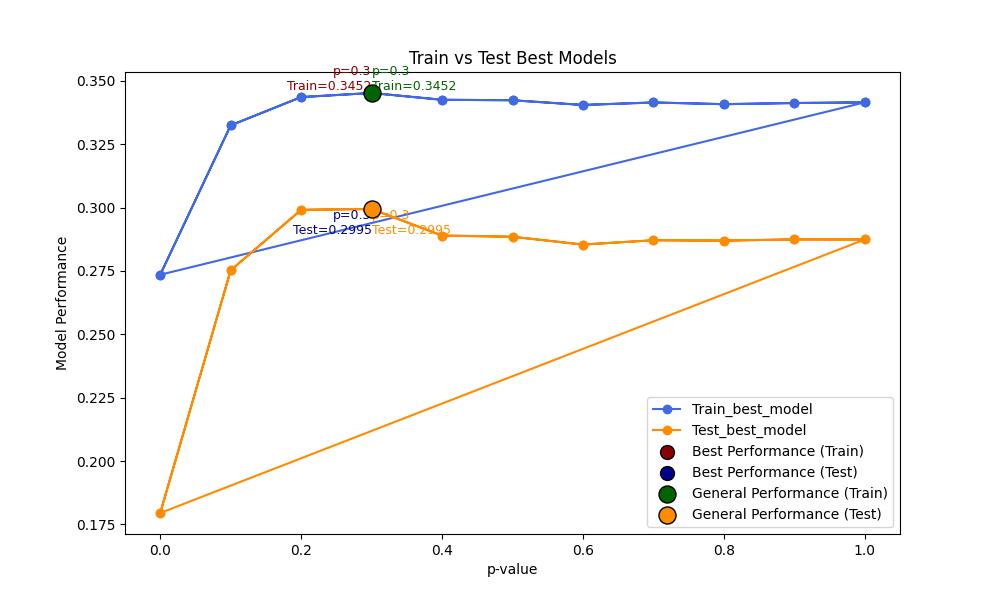

2. Reporting Generalized Performance:

|                  | 14                   |
|:-----------------|:---------------------|
| clump_p1         | 1.0                  |
| clump_r2         | 0.1                  |
| clump_kb         | 200.0                |
| p_window_size    | 200.0                |
| p_slide_size     | 50.0                 |
| p_LD_threshold   | 0.25                 |
| pvalue           | 0.30001              |
| numberofpca      | 6.0                  |
| tempalpha        | 0.1                  |
| l1weight         | 0.1                  |
| Train_pure_prs   | -0.32404136178915544 |
| Train_null_model | 0.23001030414198934  |
| Train_best_model | 0.34522012022360854  |
| Test_pure_prs    | -0.2990336376476658  |
| Test_null_model  | 0.11869244971793698  |
| Test_best_model  | 0.29946176523444235  |
| PRSice-2_Model   | sum                  |
| Difference       | 0.045758354989166194 |
| Sum              | 0.6446818854580509   |
3. Reporting the correlation of hyper

<IPython.core.display.Javascript object>


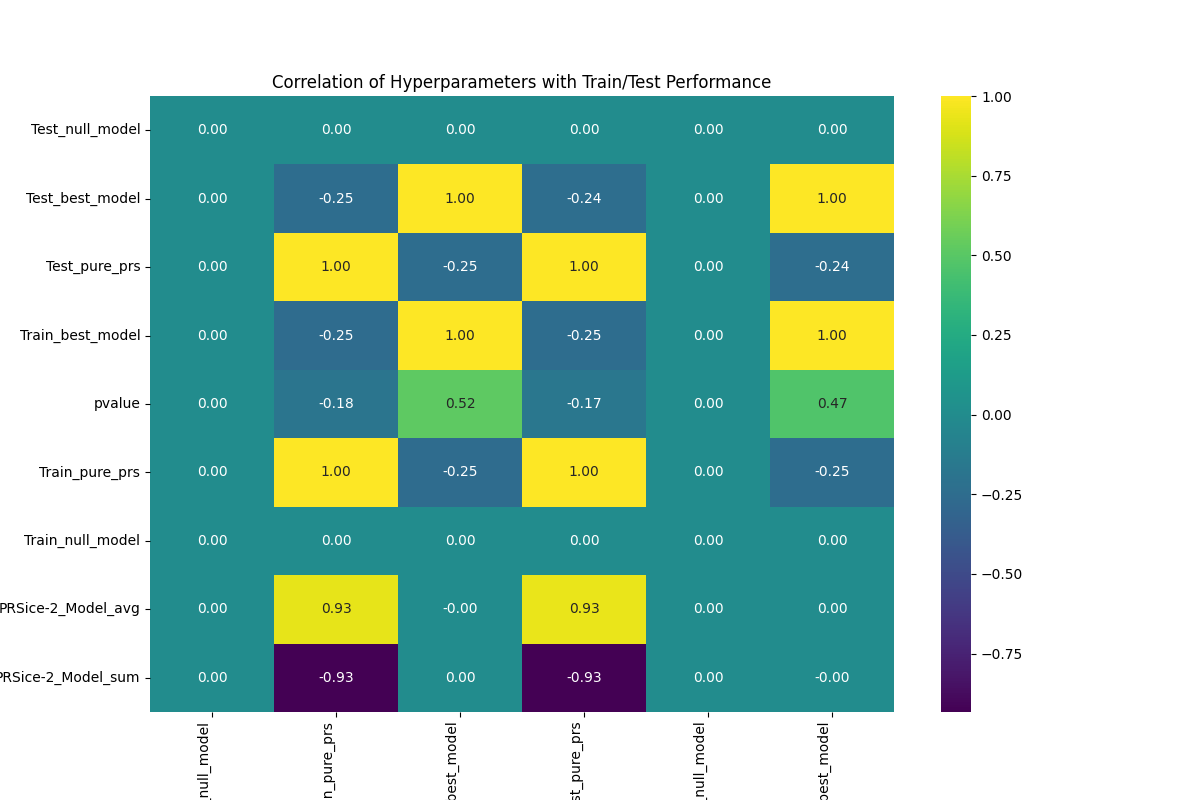

<IPython.core.display.Javascript object>


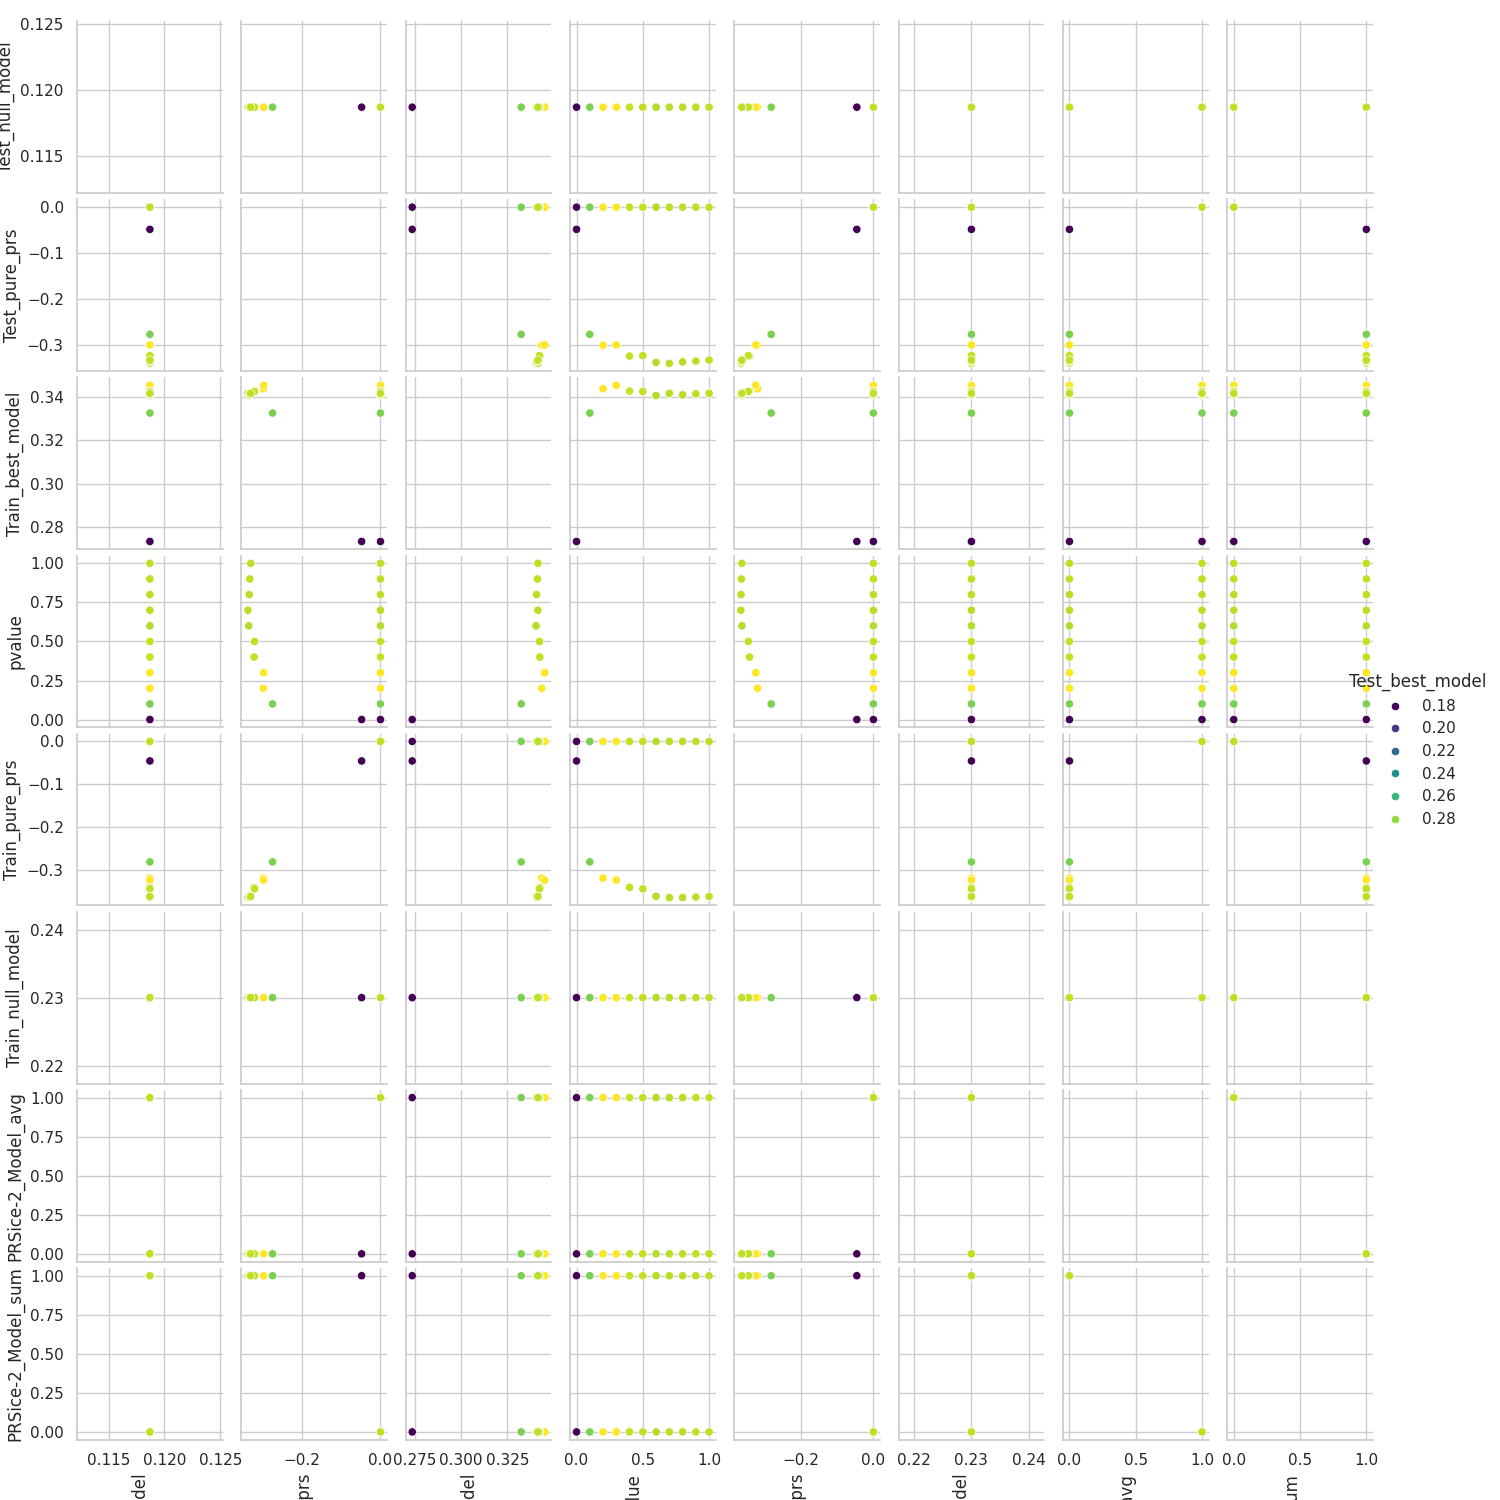

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

df = divided_result.sort_values(by='Train_best_model', ascending=False)
print("1. Reporting Based on Best Training Performance:\n")
print(df.iloc[0].to_markdown())


 
df = divided_result.copy()

# Plot Train and Test best models against p-values
plt.figure(figsize=(10, 6))
plt.plot(df['pvalue'], df['Train_best_model'], label='Train_best_model', marker='o', color='royalblue')
plt.plot(df['pvalue'], df['Test_best_model'], label='Test_best_model', marker='o', color='darkorange')

# Highlight the p-value where both train and test are high
best_index = df[['Train_best_model']].sum(axis=1).idxmax()
best_pvalue = df.loc[best_index, 'pvalue']
best_train = df.loc[best_index, 'Train_best_model']
best_test = df.loc[best_index, 'Test_best_model']

# Use dark colors for the circles
plt.scatter(best_pvalue, best_train, color='darkred', s=100, label=f'Best Performance (Train)', edgecolor='black', zorder=5)
plt.scatter(best_pvalue, best_test, color='darkblue', s=100, label=f'Best Performance (Test)', edgecolor='black', zorder=5)

# Annotate the best performance with p-value, train, and test values
plt.text(best_pvalue, best_train, f'p={best_pvalue:.4g}\nTrain={best_train:.4g}', ha='right', va='bottom', fontsize=9, color='darkred')
plt.text(best_pvalue, best_test, f'p={best_pvalue:.4g}\nTest={best_test:.4g}', ha='right', va='top', fontsize=9, color='darkblue')

# Calculate Difference and Sum
df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
df['Sum'] = df['Train_best_model'] + df['Test_best_model']

# Sort the DataFrame
sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
#sorted_df = df.sort_values(by=[ 'Difference','Sum'], ascending=[  True,False])

# Highlight the general performance
general_index = sorted_df.index[0]
general_pvalue = sorted_df.loc[general_index, 'pvalue']
general_train = sorted_df.loc[general_index, 'Train_best_model']
general_test = sorted_df.loc[general_index, 'Test_best_model']

plt.scatter(general_pvalue, general_train, color='darkgreen', s=150, label='General Performance (Train)', edgecolor='black', zorder=6)
plt.scatter(general_pvalue, general_test, color='darkorange', s=150, label='General Performance (Test)', edgecolor='black', zorder=6)

# Annotate the general performance with p-value, train, and test values
plt.text(general_pvalue, general_train, f'p={general_pvalue:.4g}\nTrain={general_train:.4g}', ha='left', va='bottom', fontsize=9, color='darkgreen')
plt.text(general_pvalue, general_test, f'p={general_pvalue:.4g}\nTest={general_test:.4g}', ha='left', va='top', fontsize=9, color='darkorange')

# Add labels and legend
plt.xlabel('p-value')
plt.ylabel('Model Performance')
plt.title('Train vs Test Best Models')
plt.legend()
plt.show()
 




print("2. Reporting Generalized Performance:\n")
df = divided_result.copy()
df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
df['Sum'] = df['Train_best_model'] + df['Test_best_model']
sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
print(sorted_df.iloc[0].to_markdown())


print("3. Reporting the correlation of hyperparameters and the performance of 'Train_null_model', 'Train_pure_prs', 'Train_best_model', 'Test_pure_prs', 'Test_null_model', and 'Test_best_model':\n")

print("3. For string hyperparameters, we used one-hot encoding to find the correlation between string hyperparameters and 'Train_null_model', 'Train_pure_prs', 'Train_best_model', 'Test_pure_prs', 'Test_null_model', and 'Test_best_model'.")

print("3. We performed this analysis for those hyperparameters that have more than one unique value.")

correlation_columns = [
 'Train_null_model', 'Train_pure_prs', 'Train_best_model',
 'Test_pure_prs', 'Test_null_model', 'Test_best_model'
]

hyperparams = [col for col in divided_result.columns if len(divided_result[col].unique()) > 1]
hyperparams = list(set(hyperparams+correlation_columns))
 
# Separate numeric and string columns
numeric_hyperparams = [col for col in hyperparams if pd.api.types.is_numeric_dtype(divided_result[col])]
string_hyperparams = [col for col in hyperparams if pd.api.types.is_string_dtype(divided_result[col])]


# Encode string columns using one-hot encoding
divided_result_encoded = pd.get_dummies(divided_result, columns=string_hyperparams)

# Combine numeric hyperparams with the new one-hot encoded columns
encoded_columns = [col for col in divided_result_encoded.columns if col.startswith(tuple(string_hyperparams))]
hyperparams = numeric_hyperparams + encoded_columns
 

# Calculate correlations
correlations = divided_result_encoded[hyperparams].corr()
 
# Display correlation of hyperparameters with train/test performance columns
hyperparam_correlations = correlations.loc[hyperparams, correlation_columns]
 
hyperparam_correlations = hyperparam_correlations.fillna(0)

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(hyperparam_correlations, annot=True, cmap='viridis', fmt='.2f', cbar=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

# Rotate y-axis labels to horizontal
#ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center')

plt.title('Correlation of Hyperparameters with Train/Test Performance')
plt.show() 

sns.set_theme(style="whitegrid")  # Choose your preferred style
pairplot = sns.pairplot(divided_result_encoded[hyperparams],hue = 'Test_best_model', palette='viridis')

# Adjust the figure size
pairplot.fig.set_size_inches(15, 15)  # You can adjust the size as needed

for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=90, ha='right')  # X-axis labels vertical
    #ax.set_ylabel(ax.get_ylabel(), rotation=0, va='bottom')  # Y-axis labels horizontal

# Show the plot
plt.show()


